# Лабораторная работа №3

In [234]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
import random
import os
from colorama import Style
import seaborn as sns

# 1)  Bellman–Ford
Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [82]:
def BellmanFord(A, start_vertex):
    '''0. Инициализация output - вектора'''
    w = Vector(A.dtype, A.nrows) # вектор длиной равной числу вершин графа
    w[start_vertex] << 0 # путь из себя в себя равен 0
    
    '''1. Пробег по графу'''
    for i in range(A.nrows-1):
        w_old = w.dup()
        w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
            
    '''2. Проверка отсутствия циклов отрицательного веса'''
    w_old = w.dup()
    w(binary.min) << w.vxm(A, semiring.min_plus)
    if not w.isequal(w_old):
        raise Exception("В графе есть цикл отрицательного веса")
        
    '''3. Формирование ответа'''
    return w.to_dense(fill_value=float('inf'))

# 2) Bellman - Ford модифицированный
Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [116]:
def BellmanFordModify(A, start_vertices):
    '''0. Инициализация output - массива'''
    rows = start_vertices.size
    cols = A.ncols
    w = Matrix(dtypes.INT32, rows, cols)
    for i in range(rows):
        w[i, start_vertices[i]] << 0
        
    '''1. Пробег по графу'''    
    for _ in range(cols-1):
        w_old = w.dup()
        for i in range(rows):
            w[i,:](binary.min) << w[i,:].vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
            
    '''2. Проверка отсутствия циклов отрицательного веса'''
    w_old = w.dup()
    for i in range(rows):
        w[i,:](binary.min) << w[i,:].vxm(A, semiring.min_plus)
    if not w.isequal(w_old):
        raise Exception("В графе есть цикл отрицательного веса")
    
    '''3. Формирование ответа'''
    w_out = w.to_dense(fill_value=float('inf'))
    output = {}
    for i in range(rows):
        output[start_vertices[i]] = w_out[i]
    return output

# 3) Floyd–Warshall
Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [129]:
def FloydWarshall(A):
    '''0. Инициализация output - массива и необходимых параметров'''
    D, rows, cur_D = A.dup(), A.nrows, A.dup()
    
    '''1. Пробег по графу'''
    for k in range(rows):
        # временные-матрицы для удобства умножения ниже
        D_col, D_row = Matrix(dtypes.INT32, rows, rows), Matrix(dtypes.INT32, rows, rows)
        D_col[:,k]=D[:,k].dup()
        D_row[k,:]=D[k,:].dup()
        cur_D << D_col.mxm(D_row, semiring.min_plus)
        D << D.ewise_add(cur_D, op="min") #None-значения -> бесконечно большие
        
    '''2. Проверка отсутствия циклов отрицательного веса'''
    # копии D, cur_D и новые D_col, D_row
    D1, cur_D1, D_col1, D_row1 = D.dup(), cur_D.dup(), Matrix(dtypes.INT32, rows, rows), Matrix(dtypes.INT32, rows, rows)
    D_col1[:,k]=D1[:,k].dup()
    D_row1[k,:]=D1[k,:].dup()
    cur_D1 << D_col1.mxm(D_row1, semiring.min_plus)
    D1 << D1.ewise_add(cur_D1, op="min")
    if not D1.isequal(D):
        raise Exception("В графе есть цикл отрицательного веса")
    
    '''3. Формирование ответа'''
    D_out = D.to_dense(fill_value=float('inf'))
    # диагональные элементы равны 0 (из вершины в себя)
    for i in range(len(D_out)):
        D_out[i, i] = 0
        
    output = {}
    for i in range(rows):
        output[i] = D_out[i]
    return output

# 4) Transitive Closure
Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [147]:
def TransitiveClosure(A):
    '''0. Создание единичной матрицы'''
    rows = A.nrows
    I = Matrix(dtypes.INT32, rows, rows)
    for i in range(rows):
        I[i,i] << 1
    D = I.dup()
    
    '''1. Пробег по графу'''
    for i in range(rows):
        D1 = D.dup()
        D = D.mxm(A, semiring.min_plus).ewise_add(I, op="min")
        if D1.isequal(D):
            break
    
    '''2. Проверка отсутствия циклов отрицательного веса'''
    D2 = D.dup()
    D2 = D2.mxm(A, semiring.min_plus).ewise_add(I, op="min")
    if not D2.isequal(D):
        raise Exception("В графе есть цикл отрицательного веса")
    
    '''3. Формирование ответа'''
    D_out = D.to_dense(fill_value=float('inf'))      
    output = {}
    for i in range(rows):
        output[i] = D_out[i] - 1
    return output

# 5) Проверка корректности работы алгоритмов

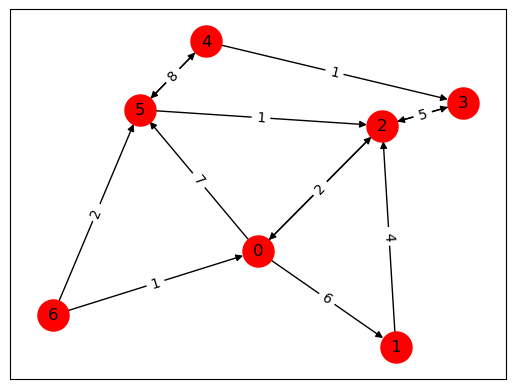

In [83]:
'''а) Создадим граф с 7 вершинами'''
matrix1 = np.array([
    [0, 6, 2, 0, 0, 7, 0],
    [0, 0, 4, 0, 0, 0, 0],
    [2, 0, 0, 5, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 8, 0],
    [0, 0, 1, 0, 8, 0, 0],
    [1, 0, 0, 0, 0, 2, 0]
])
M1 = gb.Matrix.from_dense(matrix1, missing_value=0)

gb.viz.draw(M1)

In [197]:
'''Для Беллман-Форда:'''
#### При обходе из вершины 0:
# до 0: 0; до 1: 0-1 -> 6; до 2: 0-2 -> 2; до 3: 0-2-3 -> 7; до 4: 0-5-4 -> 15; до 5: 0-5 -> 7; до 6: никак
#### При обходе из вершины 1:
# до 0: 1-2-0 -> 6; до 1: 0; до 2: 1-2 -> 4; до 3: 1-2-3 -> 9; до 4: 1-2-0-5-4 -> 21; до 5: 1-2-0-5 -> 13; до 6: никак
#### При обходе из вершины 2:
# до 0: 2-0 -> 2; до 1: 2-0-1 ->8; до 2: 0; до 3: 2-3 -> 5; до 4: 2-0-5-4 -> 17; до 5: 2-0-5 -> 9; до 6: никак
#### При обходе из вершины 3:
# до 0: 3-2-0 -> 7; до 1: 3-2-0-1 -> 13; до 2: 3-2 -> 5; до 3: 0; до 4: 3-2-0-5-4 -> 22; до 5: 3-2-0-5 -> 14; до 6: никак
#### При обходе из вершины 4:
# до 0: 4-3-2-0 -> 8; до 1: 4-3-2-0-1 ->14; до 2: 4-3-2 -> 6; до 3: 4-3 -> 1; до 4: 0; до 5: 4-5 -> 8; до 6: никак
#### При обходе из вершины 5:
# до 0: 5-2-0 -> 3; до 1: 5-2-0-1 ->9; до 2: 5-2 -> 1; до 3: 5-2-3 -> 6; до 4: 5-4 -> 8; до 5: 0; до 6: никак
#### При обходе из вершины 6:
# до 0: 6-0 -> 1; до 1: 6-0-1 ->7; до 2: 6-0-2 -> 3; до 3: 6-0-2-3 -> 8; до 4: 6-5-4 -> 10; до 5: 6-5 -> 2; до 6: 0
assert (BellmanFord(M1, 0)==np.array([ 0.,  6.,  2.,  7., 15.,  7., float('inf')])).all()
assert (BellmanFord(M1, 1)==np.array([ 6.,  0.,  4.,  9., 21., 13., float('inf')])).all()
assert (BellmanFord(M1, 2)==np.array([ 2.,  8.,  0.,  5., 17.,  9., float('inf')])).all()
assert (BellmanFord(M1, 3)==np.array([ 7., 13.,  5.,  0., 22., 14., float('inf')])).all()
assert (BellmanFord(M1, 4)==np.array([ 8., 14.,  6.,  1.,  0.,  8., float('inf')])).all()
assert (BellmanFord(M1, 5)==np.array([ 3.,  9.,  1.,  6.,  8.,  0., float('inf')])).all()
assert (BellmanFord(M1, 6)==np.array([ 1.,  7.,  3.,  8., 10.,  2.,  0.])).all()
print('BellmanFord примеры:')
print(f'1: {BellmanFord(M1, 1)}')
print(f'4: {BellmanFord(M1, 4)}\n')

'''Для Беллман-Форда модифицированного:'''
print('BellmanFordModify:')
print(BellmanFordModify(M1, np.array([1, 4, 3, 2])))
correct_ans =   {0: np.array([ 0.,  6.,  2.,  7., 15.,  7., float('inf')]),
                 1: np.array([ 6.,  0.,  4.,  9., 21., 13., float('inf')]),
                 2: np.array([ 2.,  8.,  0.,  5., 17.,  9., float('inf')]),
                 3: np.array([ 7., 13.,  5.,  0., 22., 14., float('inf')]),
                 4: np.array([ 8., 14.,  6.,  1.,  0.,  8., float('inf')]),
                 5: np.array([ 3.,  9.,  1.,  6.,  8.,  0., float('inf')]),
                 6: np.array([ 1.,  7.,  3.,  8., 10.,  2.,  0.])}
for i in range(7):
    assert (BellmanFordModify(M1, np.arange(7))[i] == correct_ans[i]).all()

'''Для FloydWarshall:'''    
print('\nFloydWarshall:')
print(FloydWarshall(M1))
for i in range(7):
    assert (FloydWarshall(M1)[i] == correct_ans[i]).all()

'''Для TransitiveClosure:''' 
print('\nTransitiveClosure:')
print(TransitiveClosure(M1))
for i in range(7):
    assert (TransitiveClosure(M1)[i] == correct_ans[i]).all()

BellmanFord примеры:
1: [ 6.  0.  4.  9. 21. 13. inf]
4: [ 8. 14.  6.  1.  0.  8. inf]

BellmanFordModify:
{1: array([ 6.,  0.,  4.,  9., 21., 13., inf]), 4: array([ 8., 14.,  6.,  1.,  0.,  8., inf]), 3: array([ 7., 13.,  5.,  0., 22., 14., inf]), 2: array([ 2.,  8.,  0.,  5., 17.,  9., inf])}

FloydWarshall:
{0: array([ 0.,  6.,  2.,  7., 15.,  7., inf]), 1: array([ 6.,  0.,  4.,  9., 21., 13., inf]), 2: array([ 2.,  8.,  0.,  5., 17.,  9., inf]), 3: array([ 7., 13.,  5.,  0., 22., 14., inf]), 4: array([ 8., 14.,  6.,  1.,  0.,  8., inf]), 5: array([ 3.,  9.,  1.,  6.,  8.,  0., inf]), 6: array([ 1.,  7.,  3.,  8., 10.,  2.,  0.])}

TransitiveClosure:
{0: array([ 0.,  6.,  2.,  7., 15.,  7., inf]), 1: array([ 6.,  0.,  4.,  9., 21., 13., inf]), 2: array([ 2.,  8.,  0.,  5., 17.,  9., inf]), 3: array([ 7., 13.,  5.,  0., 22., 14., inf]), 4: array([ 8., 14.,  6.,  1.,  0.,  8., inf]), 5: array([ 3.,  9.,  1.,  6.,  8.,  0., inf]), 6: array([ 1.,  7.,  3.,  8., 10.,  2.,  0.])}


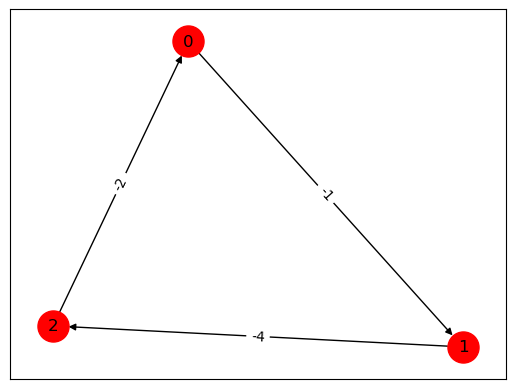

In [203]:
# На графе с циклом отрицательного веса
matrix2 = np.array([
    [0, -1, 0],
    [0, 0, -4],
    [-2, 0, 0],
   
])
M2 = gb.Matrix.from_dense(matrix2, missing_value=0)

gb.viz.draw(M2)

In [205]:
print(BellmanFord(M2, 2))

Exception: В графе есть цикл отрицательного веса

In [206]:
print(BellmanFordModify(M2, np.array([0,1,2])))

Exception: В графе есть цикл отрицательного веса

In [207]:
print(FloydWarshall(M2))

Exception: В графе есть цикл отрицательного веса

In [208]:
print(TransitiveClosure(M2))

Exception: В графе есть цикл отрицательного веса

# Часть 2. Дополнительно

# а) 
Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта [SuiteSparse Matrix Collection](https://sparse.tamu.edu) и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).

In [235]:
# названия скачанных графов
graph_names = os.listdir('DataLab3/') 

In [243]:
def compare_all(A, vertices):
    '''A - граф, vertices - вершины'''
    print('Bellman Ford:')
    %timeit [BellmanFord(A, vert) for vert in vertices]
    
    print('Bellman Ford Modify:')
    %timeit BellmanFordModify(A, vertices)


def time_ffloyd_transitive(A):
    print('FloydWarshall:')
    %timeit FloydWarshall(A)

    print('TransitiveClosure:')
    %timeit TransitiveClosure(A)
    print()

    
def vertices_generator(n, p):
    '''
    генерация массива стартовых вершин
    n - количество вершин в графе
    p - доля генерируемых стартовых вершин'''
    return np.array(random.sample(range(n), round(n * p)))       

### а1) Сравнение алгоритмов на графах с сайта

In [244]:
'''Зависимости времени от размера графа (и степени разреженности) + от числа стартовых вершин'''
# 1. Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'DataLab3/{graph_name}')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name} (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    time_ffloyd_transitive(graph)
    # 2. Зависимость времени работы от числа стартовых вершин
    for p in p_all:
        vertices = vertices_generator(graph.nrows, p)
        print('Доля стартовых вершин:', p)
        compare_all(graph, vertices)
        print()

Для can_1054.mtx (Количество вершин: 1054, количество ребер: 12196), степень разреженности: 0.0110
FloydWarshall:
17.7 s ± 75.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TransitiveClosure:
565 ms ± 36.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Доля стартовых вершин: 0.1
Bellman Ford:
423 ms ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
1.74 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Доля стартовых вершин: 0.4
Bellman Ford:
1.71 s ± 68.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
7.29 s ± 278 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Доля стартовых вершин: 0.7
Bellman Ford:
3.04 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
13 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Доля стартовых вершин: 1.0
Bellman Ford:
4.33 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
19.7 s ±

### Комментарии:
1) По результатам тестирования можно отметить, что алгоритм Bellman Ford Modify работает медленнее, чем обычный Bellman Ford. Это связано с тем, что относительно долго происходит проверка графа на то, есть ли цикл отрицательного веса.
2) TransitiveClosure во всех случаях отрабатывал значительно быстрее, чем FloydWarshall.
3) Если сравнивать алгоритмы TransitiveClosure с Bellman Ford в зависимости от доли стартовых вершин, то во всех трех случаях при доле стартовых вершин = 0.4 TransitiveClosure начинает рассчитывать ответ быстрее, чем Bellman Ford, а при доле стартовых вершин меньше, чем 0.4, в частности при 0.1, Bellman Ford еще быстрее.

### а2) Сравнение алгоритмов на сгенерированных графах

In [248]:
def generate_graph(num_vertices, num_edges):
    '''создание множества, состоящего из номеров ячеек матрицы (без диагональных элементов)'''
    positions=[]
    for ind in range(num_vertices**2):
        if ind // num_vertices != ind % num_vertices:
            positions.append(ind)

    '''Отбор num_edges случайных индексов вершин (случайные значения из high_positions) для создания ребер'''
    gen_indices = random.sample(positions, num_edges)
    
    '''Преобразование индексов в координаты (строка, столбец)'''
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))
    
    return gb.Matrix.from_coo(row_indices, col_indices, [random.randint(0, 10) for _ in range(len(row_indices))], 
                              nrows=num_vertices, ncols=num_vertices)

### i) Зависимость от числа вершин (при фикс степени разреженности и фикс числе стартовых вершин)

In [251]:
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50 # фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    time_ffloyd_transitive(generated_graph)
    compare_all(generated_graph, vertices_generator(i, num_starts / 100))

Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
FloydWarshall:
156 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
TransitiveClosure:
36.5 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Bellman Ford:
144 ms ± 8.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Bellman Ford Modify:
300 ms ± 37.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
FloydWarshall:
343 ms ± 28.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TransitiveClosure:
96.8 ms ± 4.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Bellman Ford:
492 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
856 ms ± 67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
FloydWarshall:
1.8 s ± 73.7 ms per loop (mean ± std. dev. of 7 runs,

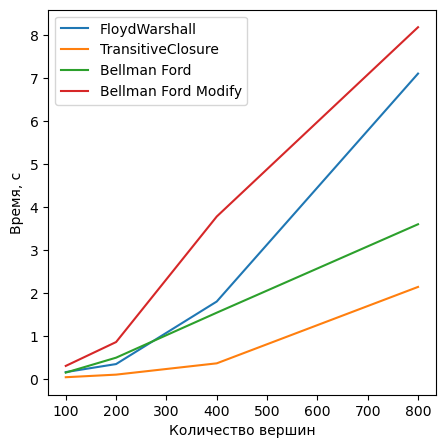

In [276]:
floyd = [0.156, 0.343, 1.8, 7.11]
transit = [0.0365, 0.0968, 0.36, 2.14]
bf = [0.144, 0.492, 1.54, 3.6]
bf_mod = [0.3, 0.856, 3.78, 8.19]
nums = [100, 200, 400, 800]

fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(y=floyd, x=nums, label='FloydWarshall', markers=True)
sns.lineplot(y=transit, x=nums, label='TransitiveClosure')
sns.lineplot(y=bf, x=nums, label='Bellman Ford')
sns.lineplot(y=bf_mod, x=nums, label='Bellman Ford Modify')
plt.xlabel('Количество вершин')
plt.ylabel('Время, с')
plt.show()

#### Выводы:

Сравнивая зависимости времени отработки алгоритмов от количества вершин графа при фиксированных остальных параметрах, TransitiveClosure является самым быстрым алгоритмом; Можно заметить, что алгоритм Bellman Ford (и его модифицированная версия) демонстрируют практически линейную зависимость, поэтому можно предположить, что на графах с большим числом вершин он будет быстрее, чем тот же FloydWarshall. Однако при небольшом числе вершин (до 200) время FloydWarshall будет меньше, чем у Bellman Ford, но за счет нелинейной зависимости с увеличением числа вершин FloydWarshall начинает сильно отставать от своих "коллег".


### ii) Зависимость от степени разреженности (при фикс числе вершин и фикс числе стартовых вершин)

In [253]:
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    time_ffloyd_transitive(generated_graph)
    compare_all(generated_graph, vertices_generator(num_vert, num_starts / 100)) 

Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
FloydWarshall:
2.97 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TransitiveClosure:
175 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Bellman Ford:
720 ms ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
2.62 s ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
FloydWarshall:
2.93 s ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TransitiveClosure:
219 ms ± 5.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Bellman Ford:
769 ms ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
3.4 s ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
FloydWarshall:
3.01 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

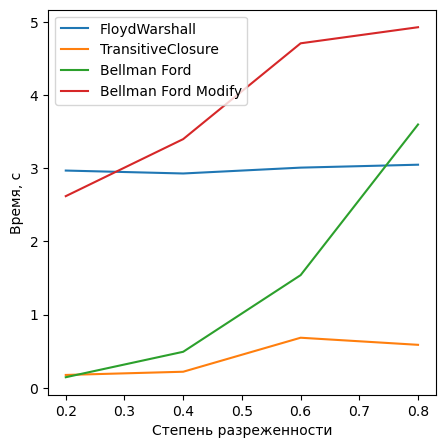

In [277]:
floyd = [2.97, 2.93, 3.01, 3.05]
transit = [0.175, 0.219, 0.684, 0.587]
bf = [0.144, 0.492, 1.54, 3.6]
bf_mod = [2.62, 3.4, 4.71, 4.93]
nums = [0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(y=floyd, x=nums, label='FloydWarshall', markers=True)
sns.lineplot(y=transit, x=nums, label='TransitiveClosure')
sns.lineplot(y=bf, x=nums, label='Bellman Ford')
sns.lineplot(y=bf_mod, x=nums, label='Bellman Ford Modify')
plt.xlabel('Степень разреженности')
plt.ylabel('Время, с')
plt.show()

### Выводы:
Сравнивая зависимости времени отработки алгоритмов от степени разреженности графа при фиксированных остальных параметрах, TransitiveClosure является самым быстрым алгоритмом; Можно заметить, что FloydWarshall не зависит от степени разреженности графа, TransitiveClosure - тоже практически не зависит, Bellman Ford Modify имеет примерно линейную зависимость, а классический Bellman Ford степенную.

### iii) Зависимость от числа стартовых вершин (при фикс числе вершин и фикс степени разреженности)

In [254]:
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5 # фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    print(Style.RESET_ALL, end='')
    time_ffloyd_transitive(generated_graph)
    compare_all(generated_graph, vertices_generator(num_vert, i / 100)) 

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
FloydWarshall:
3.07 s ± 99.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TransitiveClosure:
670 ms ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Bellman Ford:
907 ms ± 41.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
1.4 s ± 389 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
FloydWarshall:
3.13 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TransitiveClosure:
672 ms ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Bellman Ford:
1.77 s ± 47.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Bellman Ford Modify:
3.49 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 60%
FloydWarshall:
2.98 s ± 62.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop ea

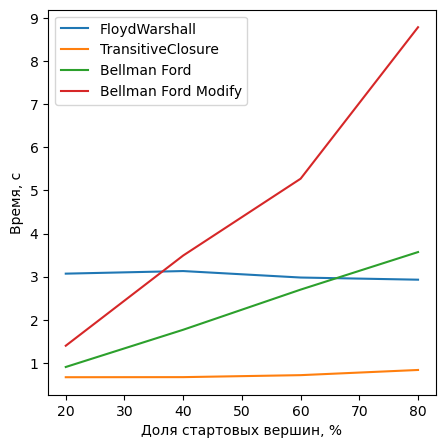

In [279]:
floyd = [3.07, 3.13, 2.98, 2.93]
transit = [0.67, 0.672, 0.718, 0.838]
bf = [0.907, 1.77, 2.7, 3.57]
bf_mod = [1.4, 3.49, 5.27, 8.78]
nums = [20, 40, 60, 80]

fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(y=floyd, x=nums, label='FloydWarshall')
sns.lineplot(y=transit, x=nums, label='TransitiveClosure')
sns.lineplot(y=bf, x=nums, label='Bellman Ford')
sns.lineplot(y=bf_mod, x=nums, label='Bellman Ford Modify')
plt.xlabel('Доля стартовых вершин, %')
plt.ylabel('Время, с')
plt.show()

### Выводы:
Очевидно, что у алгоритмов TransitiveClosure и FloydWarshall нет зависимости от доли стартовых вершин, ведь расчет происходит для всех вершин; а Bellman Ford вместе с модифицированной версией показывают линейную зависимость от доли стартовых вершин.

# б) Оценить эффект от использования push/pull direction optimization
для векторно-матричных операциях в алгоритмах. <br>Попробовать разные стратегии (всегда push, всегда pull, использовать порог наполненности вектора и т.д.).

In [285]:
def BellmanFord_push_pull(A, start_vertex, push_pull_percent=0.0):
    '''0. Инициализация output - вектора'''
    w = Vector(A.dtype, A.nrows) # вектор длиной равной числу вершин графа
    w[start_vertex] << 0 # путь из себя в себя равен 0
    
    '''1. Пробег по графу'''
    for i in range(A.nrows-1):
        w_old = w.dup()
        # push
        if push_pull_percent == 0.0:
            w(binary.min) << w.vxm(A, semiring.min_plus)
        # pull
        elif push_pull_percent == 1.0:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        # порог наполняемости
        else:
            if w.nvals / w.size > push_pull_percent:
                w(binary.min) << A.T.mxv(w, semiring.min_plus)
            else:
                w(binary.min) << w.vxm(A, semiring.min_plus)
        
        if w.isequal(w_old):
            break
            
    '''2. Проверка отсутствия циклов отрицательного веса'''
    w_old = w.dup()
    # push
    if push_pull_percent == 0.0:
        w(binary.min) << w.vxm(A, semiring.min_plus)
    
    # pull
    elif push_pull_percent == 1.0:
        w(binary.min) << A.T.mxv(w, semiring.min_plus)
    
    # порог наполняемости
    else:
        if w.nvals / w.size > push_pull_percent:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        else:
            w(binary.min) << w.vxm(A, semiring.min_plus)
    
    if not w.isequal(w_old):
        raise Exception("В графе есть цикл отрицательного веса")
        
    '''3. Формирование ответа'''
    return w.to_dense(fill_value=float('inf'))

In [286]:
def BellmanFordModify_push_pull(A, start_vertices, push_pull_percent=0.0):
    '''0. Инициализация output - массива'''
    rows = start_vertices.size
    cols = A.ncols
    w = Matrix(dtypes.INT32, rows, cols)
    for i in range(rows):
        w[i, start_vertices[i]] << 0
        
    '''1. Пробег по графу'''    
    for _ in range(cols-1):
        w_old = w.dup()
        for i in range(rows):
            #push
            if push_pull_percent == 0.0:
                w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
                
            # pull
            elif push_pull_percent == 1.0:
                w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
                
            # порог наполняемости
            else:
                if w[i, :].nvals / w[i, :].size > push_pull_percent:
                    w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
                else:
                    w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
                    
        if w.isequal(w_old):
            break
            
    '''2. Проверка отсутствия циклов отрицательного веса'''
    w_old = w.dup()
    for i in range(rows):
        # push
        if push_pull_percent == 0.0:
            w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
            
        # pull
        elif push_pull_percent == 1.0:
            w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
            
        # порог наполняемости
        else:
            if w[i, :].nvals / w[i, :].size > push_pull_percent:
                w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
            else:
                w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
                
    if not w.isequal(w_old):
        raise Exception("В графе есть цикл отрицательного веса")
    
    '''3. Формирование ответа'''
    w_out = w.to_dense(fill_value=float('inf'))
    output = {}
    for i in range(rows):
        output[start_vertices[i]] = w_out[i]
    return output

In [288]:
# Для Bellman Ford
num_vert, fix_raref_deg = 1000, 0.5 # фиксированные число вершин и значение степени разреженности
generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
num_vertices = generated_graph.shape[0]
num_edges = len(generated_graph.to_coo()[0])
rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, число стартовых вершин: 100\n')
print(Style.RESET_ALL, end='')

for i in [0.0, 0.1, 0.3, 0.7, 1.0]:  # уровень порога наполняемости (0 - пуш, 1 - пул)
    print(f'уровень push/pull: {i}')
    %timeit BellmanFord_push_pull(graph, np.arange(100), push_pull_percent=i) 
    print()

Количество вершин: 1000, степень разреженности: 0.50, число стартовых вершин: 100

уровень push/pull: 0.0
884 µs ± 108 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

уровень push/pull: 0.1
859 µs ± 34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

уровень push/pull: 0.3
891 µs ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

уровень push/pull: 0.7
878 µs ± 97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

уровень push/pull: 1.0
890 µs ± 117 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



### Комментарий:
Видно, что время выполнения алгоритма Беллмана Форда не сильно зависит от уровня push/pull optimization. В рассмотренном случае, когда граф имеет 1000 вершин, степень разреженности = 0.5 и когда число стартовых вершин = 100, время выполнения колеблется в диапазоне от 859 до 891 микросекунды для разных уровней push/pull optimization. Чуть более лучший результат получился при уровне push/pull = 0.1, при этом еще дисперсия меньше, чем в остальных экспериментах.


In [289]:
# Для Bellman Ford Modify
num_vert, fix_raref_deg = 1000, 0.5 # фиксированные число вершин и значение степени разреженности
generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
num_vertices = generated_graph.shape[0]
num_edges = len(generated_graph.to_coo()[0])
rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, число стартовых вершин: 100\n')
print(Style.RESET_ALL, end='')

for i in [0.0, 0.1, 0.3, 0.7, 1.0]:  # уровень порога наполняемости (0 - пуш, 1 - пул)
    print(f'уровень push/pull: {i}')
    %timeit BellmanFordModify_push_pull(graph, np.arange(100), push_pull_percent=i) 
    print()

Количество вершин: 1000, степень разреженности: 0.50, число стартовых вершин: 100

уровень push/pull: 0.0
619 ms ± 76.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

уровень push/pull: 0.1
899 ms ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

уровень push/pull: 0.3
874 ms ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

уровень push/pull: 0.7
861 ms ± 92.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

уровень push/pull: 1.0
604 ms ± 57.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



### Комментарий:
Видно, что время выполнения модифицированного алгоритма Беллмана Форда не сильно, но зависит от уровня push/pull optimization. В рассмотренном случае, когда граф имеет 1000 вершин, степень разреженности = 0.5 и когда число стартовых вершин = 100, время выполнения колеблется в диапазоне от 604 до 899 миллисекунд для разных уровней push/pull optimization, причем на "краях" наблюдаются меньшие временные значения: лучшее время показал алгоритм с уровнем 1.0 (pull) и чуть помедленнее отработал алгоритм с уровнем 0.0 (push). Таким образом, можно сделать вывод о том, что стоит применять либо стратегию push либо pull, а не какое-то промежуточное значение.